<a href="https://colab.research.google.com/github/ad-astra-per-ardua/DataAnalysis/blob/main/LTSM_Model_Task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [178]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.optimizers import Adam
import yfinance as yf
from tensorflow.keras.regularizers import l2
from statsmodels.tsa.seasonal import seasonal_decompose
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.losses import Huber
from statsmodels.tsa.filters.hp_filter import hpfilter
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.optimizers.schedules import CosineDecay

scaler = StandardScaler()
loss_function = Huber(delta=1.0)
loss_function2 = log_cosh(delta=1.0)


In [179]:
log_dir = "./logs"
stock_data = yf.download('AAPL', start='2020-01-01', end='2023-01-01')
closing_prices = stock_data['Close'].values

closing_prices = pd.Series(closing_prices.flatten()).interpolate().values
scaled_data = scaler.fit_transform(closing_prices.reshape(-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
closing_prices_scaled = scaler.fit_transform(closing_prices.reshape(-1, 1))

[*********************100%***********************]  1 of 1 completed


In [180]:
def create_sequences(data, sequence_length=60):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length])
    return np.array(X), np.array(y)

sequence_length = 60
X, y = create_sequences(closing_prices_scaled, sequence_length)

train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")

X_train shape: (556, 60, 1), y_train shape: (556, 1)


In [181]:
def add_noise(data, noise_factor=0.02):
    noise = noise_factor * np.random.normal(size=data.shape)
    return data + noise

X_train_noisy = add_noise(X_train)

model = Sequential([
    Bidirectional(LSTM(512, return_sequences=True, input_shape=(sequence_length, 1))),
    Dropout(0.3),
    LSTM(256, return_sequences=True),
    Dropout(0.3),
    LSTM(128, return_sequences=False),
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.001), loss=loss_function, metrics=['mae'])
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint('enhanced_lstm_model.keras', save_best_only=True, monitor='val_loss'),
    TensorBoard(log_dir="./logs"),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
]
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [182]:
history = model.fit(
    X_train_noisy, y_train,
    validation_data=(X_test, y_test),
    epochs=150,
    batch_size=128,
    callbacks=callbacks
)

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.9681 - mae: 0.4330 - val_loss: 0.8711 - val_mae: 0.4086 - learning_rate: 0.0010
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step - loss: 0.8140 - mae: 0.2328 - val_loss: 0.7409 - val_mae: 0.0714 - learning_rate: 0.0010
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - loss: 0.7327 - mae: 0.0814 - val_loss: 0.7011 - val_mae: 0.1266 - learning_rate: 0.0010
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - loss: 0.6879 - mae: 0.0952 - val_loss: 0.6521 - val_mae: 0.0873 - learning_rate: 0.0010
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - loss: 0.6411 - mae: 0.0645 - val_loss: 0.6064 - val_mae: 0.0567 - learning_rate: 0.0010
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - loss: 0.5973 - mae: 0.0491 - val_loss: 0.5654 - val_mae: 0.0506 - learning_rate: 0.0010
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - loss: 0.5570 - mae: 0.0472 - val_loss: 0.5268 - val_mae: 0.0495 - learning_rate: 0.0010
Epoch 8/100
5

In [183]:
# Declare visualizing plots

def plot_predictions(actual, predicted, title="Price Prediction"):
    plt.figure(figsize=(12, 6))
    plt.plot(actual, label='Actual Prices', color='blue')
    plt.plot(predicted, label='Predicted Prices', color='red')
    plt.fill_between(range(len(actual)), actual.flatten(), predicted.flatten(), color="gray", alpha=0.2)
    plt.title(title)
    plt.xlabel('Days')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

def compare_predictions(actual, predicted):
    plt.figure(figsize=(12, 6))
    plt.plot(actual, label="Actual Prices", color="blue")
    plt.plot(predicted, label="Predicted Prices", color="red")
    plt.fill_between(range(len(actual)), actual.flatten(), predicted.flatten(), color="gray", alpha=0.2)
    plt.title("Prediction vs Actual with Differences")
    plt.xlabel("Days")
    plt.ylabel("Price")
    plt.legend()
    plt.show()

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step


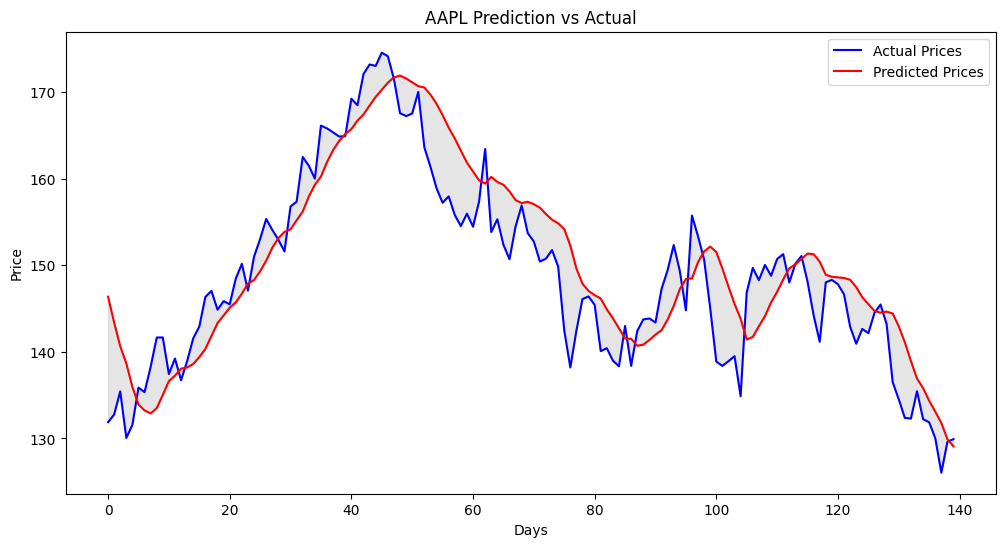

In [184]:
predicted_prices = model.predict(X_test)

predicted_prices = scaler.inverse_transform(predicted_prices)
actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

plot_predictions(actual_prices, predicted_prices, title="AAPL Prediction vs Actual")

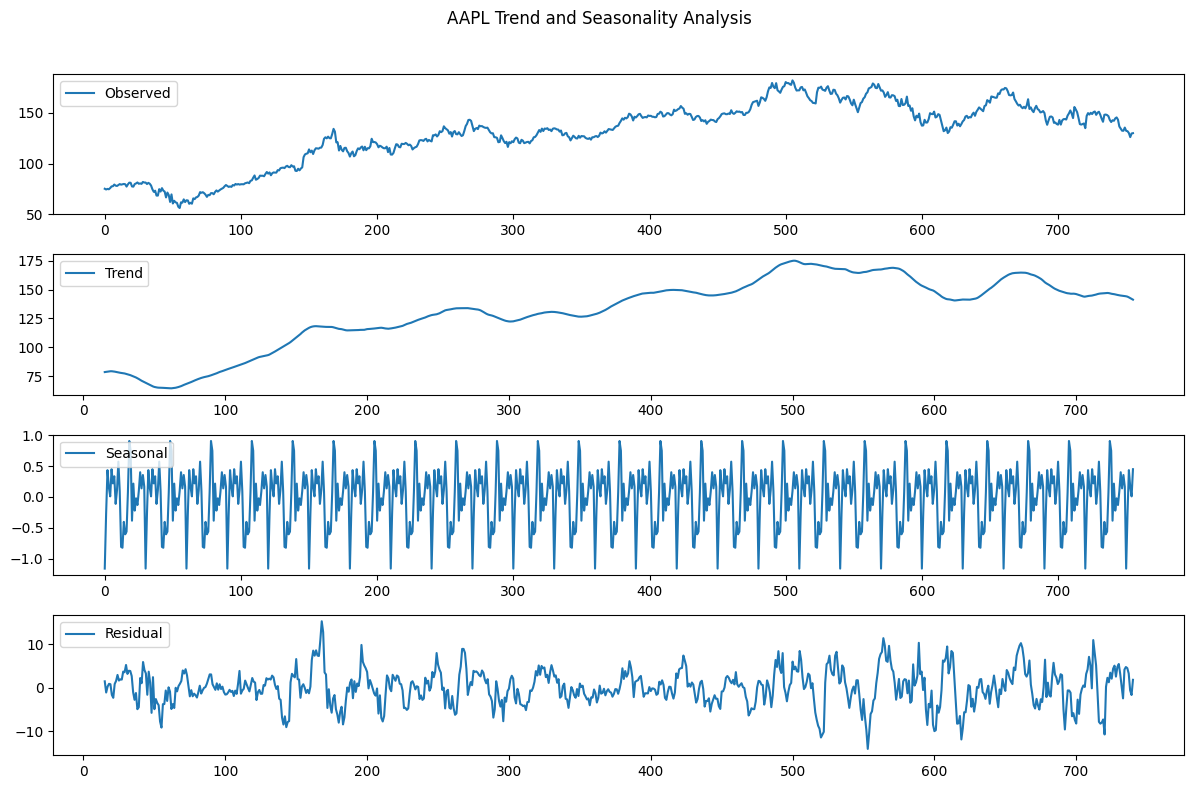

In [185]:
# Seasonality and trend

def plot_trend_and_seasonality(data, title="Trend and Seasonality Analysis"):
    result = seasonal_decompose(data, model='additive', period=30)
    plt.figure(figsize=(12, 8))
    plt.subplot(411)
    plt.plot(result.observed, label='Observed')
    plt.legend(loc='upper left')
    plt.subplot(412)
    plt.plot(result.trend, label='Trend')
    plt.legend(loc='upper left')
    plt.subplot(413)
    plt.plot(result.seasonal, label='Seasonal')
    plt.legend(loc='upper left')
    plt.subplot(414)
    plt.plot(result.resid, label='Residual')
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.suptitle(title)
    plt.subplots_adjust(top=0.9)
    plt.show()

def detrend_data(data):
    result = seasonal_decompose(data, model='additive', period=30)
    detrended = data - result.trend
    detrended = pd.Series(detrended).fillna(0).values
    return detrended

plot_trend_and_seasonality(closing_prices, title="AAPL Trend and Seasonality Analysis")
closing_prices_detrended = detrend_data(closing_prices)
closing_prices_detrended_scaled = scaler.fit_transform(closing_prices_detrended.reshape(-1, 1))

In [186]:
train_size = int(len(X_detrended) * 0.8)
X_train_detrended, X_test_detrended = X_detrended[:train_size], X_detrended[train_size:]
y_train_detrended, y_test_detrended = y_detrended[:train_size], y_detrended[train_size:]

closing_prices_detrended = detrend_data(closing_prices)
closing_prices_detrended_scaled = scaler.fit_transform(closing_prices_detrended.reshape(-1, 1))
X_detrended, y_detrended = create_sequences(closing_prices_detrended, sequence_length)
X_train_detrended = X_train_detrended.reshape(X_train_detrended.shape[0], X_train_detrended.shape[1], 1)
X_test_detrended = X_test_detrended.reshape(X_test_detrended.shape[0], X_test_detrended.shape[1], 1)
if len(y_train_detrended.shape) == 1:
    y_train_detrended = y_train_detrended.reshape(-1, 1)
if len(y_test_detrended.shape) == 1:
    y_test_detrended = y_test_detrended.reshape(-1, 1)

In [187]:
# Prediction after Detrend

history_detrended = model.fit(
    X_train_detrended, y_train_detrended,
    validation_data=(X_test_detrended, y_test_detrended),
    epochs=100,
    batch_size=128,
    callbacks=callbacks
)


Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - loss: 2.6399 - mae: 3.0993 - val_loss: 2.8324 - val_mae: 3.2687 - learning_rate: 3.1250e-05
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 2.3194 - mae: 2.7765 - val_loss: 2.7967 - val_mae: 3.2288 - learning_rate: 3.1250e-05
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 2.4482 - mae: 2.9045 - val_loss: 2.7561 - val_mae: 3.1844 - learning_rate: 3.1250e-05
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 2.2557 - mae: 2.7084 - val_loss: 2.7176 - val_mae: 3.1422 - learning_rate: 3.1250e-05
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 2.3315 - mae: 2.7890 - val_loss: 2.6769 - val_mae: 3.0980 - learning_rate: 3.1250e-05
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 2.3046 - mae: 2.7589 - val_loss: 2.6398 - val_mae: 3.0587 - learning_rate: 3.1250e-05
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 2.2373 - mae: 2.6901 - val_loss: 2.6079 - val_mae: 3.0246 - learning_rate: 3.1

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


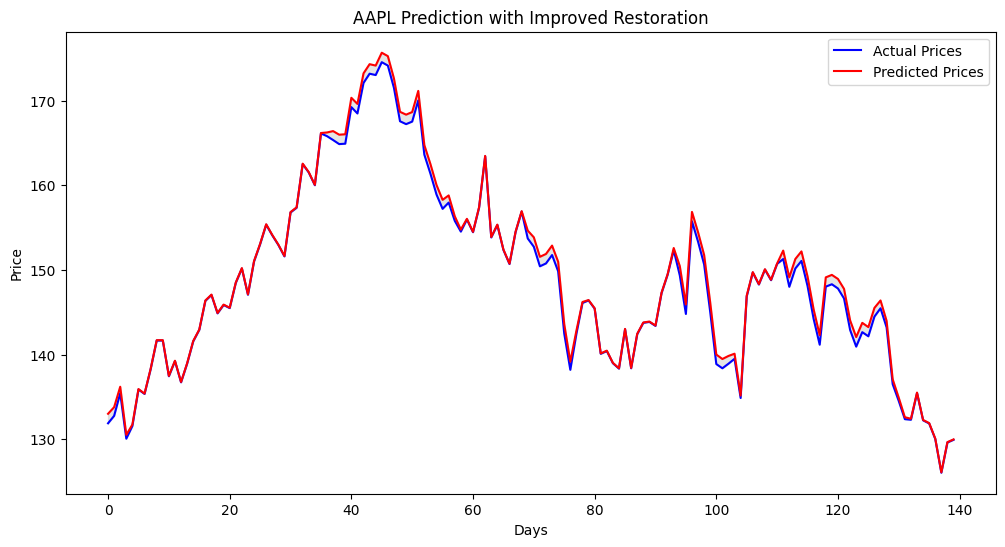

In [188]:

alpha = 0.8
beta = 1 - alpha

predicted_prices_detrended = model.predict(X_test_detrended)

start_idx = train_size + sequence_length
end_idx = start_idx + len(predicted_prices_detrended)

if end_idx > len(closing_prices):
    end_idx = len(closing_prices)

trend_component = closing_prices[start_idx:end_idx].reshape(-1, 1)

actual_prices_restored = closing_prices[start_idx:end_idx].reshape(-1, 1)
predicted_prices_restored = predicted_prices_detrended + trend_component
min_len = min(len(actual_prices_restored), len(predicted_prices_restored))
actual_prices_restored = actual_prices_restored[:min_len]
predicted_prices_restored = predicted_prices_restored[:min_len]

# fck overfitting
plot_predictions(actual_prices_restored, predicted_prices_restored, title="AAPL Prediction with Improved Restoration")


In [189]:
# Start of BTC Part
btc_data = yf.download('BTC-USD', start='2020-01-01', end='2023-01-01')
btc_closing_prices = btc_data['Close'].values
btc_closing_prices = pd.Series(btc_closing_prices.flatten()).interpolate().values

btc_scaler = MinMaxScaler(feature_range=(0, 1))
btc_closing_prices_scaled = btc_scaler.fit_transform(btc_closing_prices.reshape(-1, 1))

X_btc, y_btc = create_sequences(btc_closing_prices_scaled, sequence_length)
train_size_btc = int(len(X_btc) * 0.8)
X_train_btc, X_test_btc = X_btc[:train_size_btc], X_btc[train_size_btc:]
y_train_btc, y_test_btc = y_btc[:train_size_btc], y_btc[train_size_btc:]


[*********************100%***********************]  1 of 1 completed


In [190]:
btc_model = Sequential([
    Bidirectional(LSTM(512, return_sequences=True, input_shape=(sequence_length, 1))),
    Dropout(0.3),
    LSTM(256, return_sequences=True),
    Dropout(0.3),
    LSTM(128, return_sequences=False),
    Dense(64, activation='relu'),
    Dense(1)
])

btc_model.compile(optimizer=Adam(learning_rate=0.001), loss=loss_function, metrics=['mae'])
from tensorflow.keras.regularizers import l2

btc_model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
btc_callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint('enhanced_lstm_model.keras', save_best_only=True, monitor='val_loss'),
    TensorBoard(log_dir="./logs"),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
]
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [191]:
btc_history = btc_model.fit(
    X_train_btc, y_train_btc,
    validation_data=(X_test_btc, y_test_btc),
    epochs=150,
    batch_size=128,
    callbacks=btc_callbacks
)

Epoch 1/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 243ms/step - loss: 0.1425 - mae: 0.4138 - val_loss: 0.0359 - val_mae: 0.1732 - learning_rate: 0.0010
Epoch 2/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - loss: 0.1058 - mae: 0.3214 - val_loss: 0.0346 - val_mae: 0.1700 - learning_rate: 0.0010
Epoch 3/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 0.1033 - mae: 0.3171 - val_loss: 0.0354 - val_mae: 0.1818 - learning_rate: 0.0010
Epoch 4/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - loss: 0.0973 - mae: 0.3026 - val_loss: 0.0328 - val_mae: 0.1704 - learning_rate: 0.0010
Epoch 5/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - loss: 0.0927 - mae: 0.2883 - val_loss: 0.0303 - val_mae: 0.1545 - learning_rate: 0.0010
Epoch 6/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - loss: 0.0945 - mae: 0.2917 - val_loss: 0.0287 - val_mae: 0.1460 - learning_rate: 0.0010
Epoch 7/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - loss: 0.0883 - mae: 0.2750 - val_loss: 0.0272 - val_mae: 0.1402 - learning_rate: 0.0010
Epoch 8/150
7/

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step


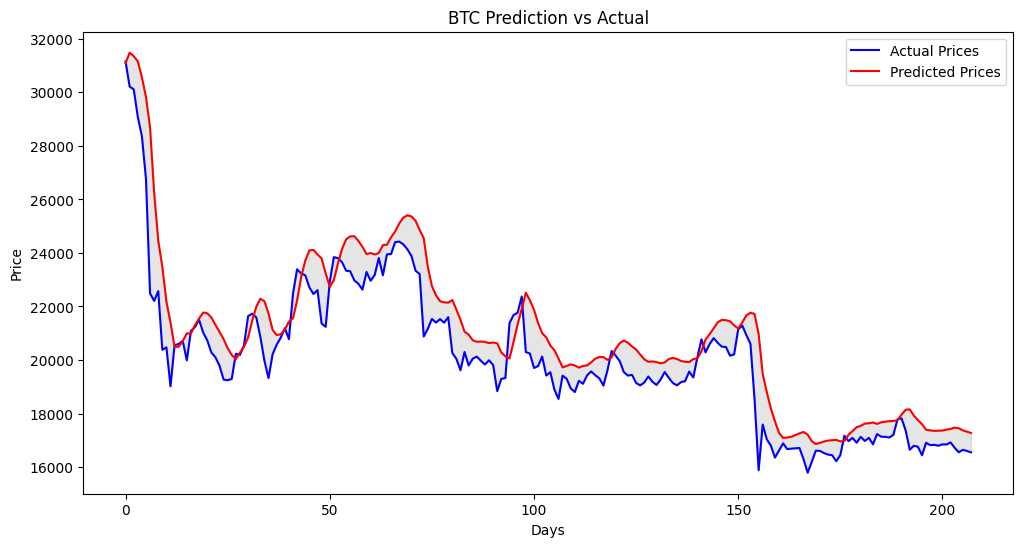

In [192]:
btc_predicted_prices = btc_model.predict(X_test_btc)
btc_predicted_prices = btc_scaler.inverse_transform(btc_predicted_prices)
btc_actual_prices = btc_scaler.inverse_transform(y_test_btc.reshape(-1, 1))
btc_predicted_prices = btc_predicted_prices.mean(axis=1).reshape(-1, 1)

min_len = min(len(btc_actual_prices), len(btc_predicted_prices))
btc_actual_prices = btc_actual_prices[:min_len]
btc_predicted_prices = btc_predicted_prices[:min_len]

plot_predictions(btc_actual_prices, btc_predicted_prices, title="BTC Prediction vs Actual")


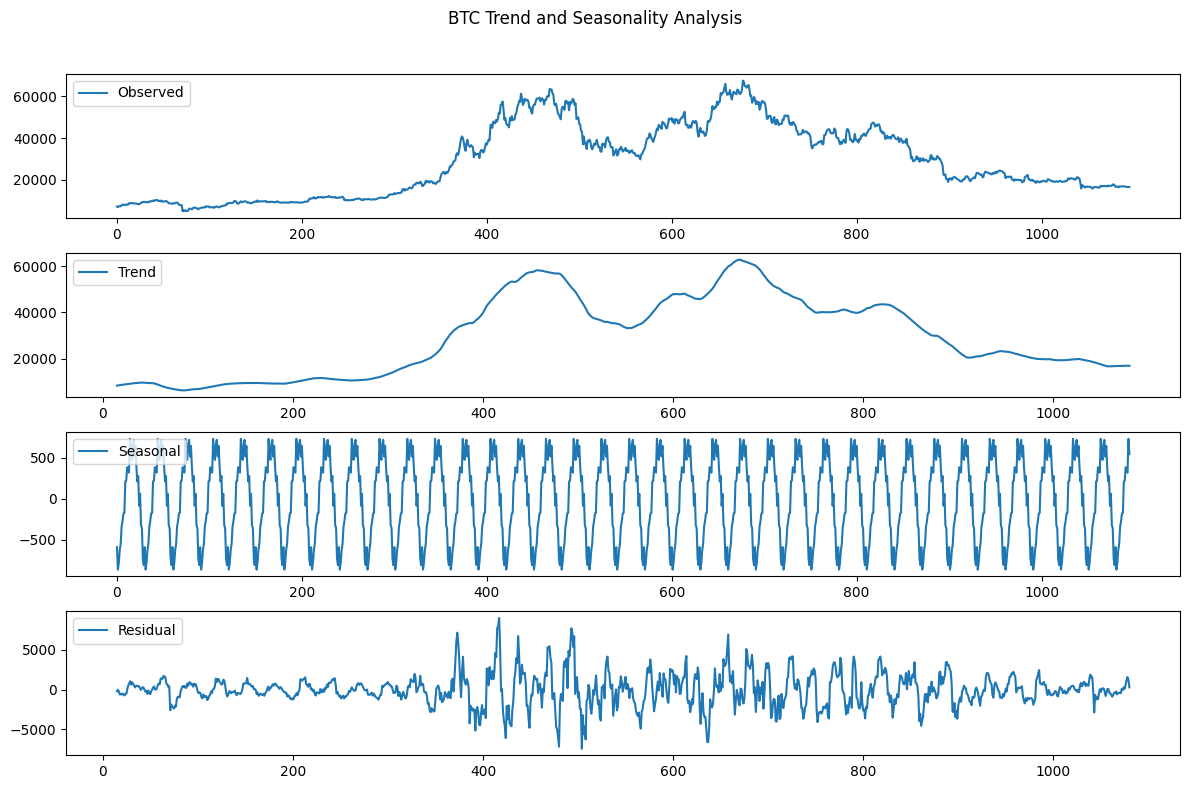

In [193]:
plot_trend_and_seasonality(btc_closing_prices, title="BTC Trend and Seasonality Analysis")


In [194]:
# BTC Detrend
btc_closing_prices_detrended = detrend_data(btc_closing_prices)
btc_closing_prices_detrended_scaled = btc_scaler.fit_transform(btc_closing_prices_detrended.reshape(-1, 1))


In [195]:
# Create detrend Sequence
X_btc_detrended, y_btc_detrended = create_sequences(btc_closing_prices_detrended_scaled, sequence_length)
X_train_btc_det, X_test_btc_det = X_btc_detrended[:train_size_btc], X_btc_detrended[train_size_btc:]
y_train_btc_det, y_test_btc_det = y_btc_detrended[:train_size_btc], y_btc_detrended[train_size_btc:]


In [198]:
# Training model
btc_history_detrended = btc_model.fit(
    X_train_btc_det, y_train_btc_det,
    validation_data=(X_test_btc_det, y_test_btc_det),
    epochs=100,
    batch_size=128,
    callbacks=btc_callbacks
)

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0057 - mae: 0.0658 - val_loss: 0.0020 - val_mae: 0.0329 - learning_rate: 3.9063e-06
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0052 - mae: 0.0642 - val_loss: 0.0020 - val_mae: 0.0323 - learning_rate: 3.9063e-06
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0052 - mae: 0.0652 - val_loss: 0.0019 - val_mae: 0.0318 - learning_rate: 3.9063e-06
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0048 - mae: 0.0610 - val_loss: 0.0019 - val_mae: 0.0316 - learning_rate: 3.9063e-06
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0046 - mae: 0.0604 - val_loss: 0.0019 - val_mae: 0.0316 - learning_rate: 3.9063e-06
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0050 - mae: 0.0630 - val_loss: 0.0019 - val_mae: 0.0316 - learning_rate: 3.9063e-06
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0050 - mae: 0.0633 - val_loss: 0.0019 - val_mae: 0.0316 - lear

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
btc_actual_prices_restored shape: (208, 1)
btc_predicted_prices_restored shape: (208, 1)


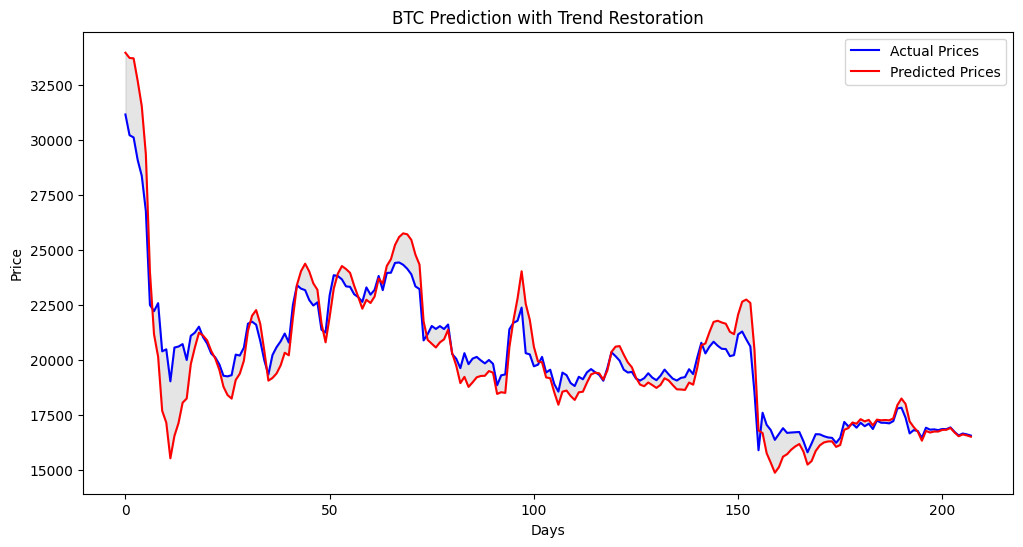

In [199]:
btc_predicted_prices_detrended = btc_model.predict(X_test_btc_det)

# 예측 결과의 평균값(중앙값)을 사용하여 단일 출력으로 변환
btc_predicted_prices_detrended = btc_predicted_prices_detrended.mean(axis=1).reshape(-1, 1)

start_idx = train_size_btc + sequence_length
end_idx = start_idx + len(btc_predicted_prices_detrended)

if end_idx > len(btc_closing_prices):
    end_idx = len(btc_closing_prices)

# 추세 성분
trend_component = btc_closing_prices[start_idx:end_idx].reshape(-1, 1)

# 예측 값 복원
btc_predicted_prices_restored = btc_scaler.inverse_transform(btc_predicted_prices_detrended) + trend_component

# 실제 값 복원
btc_actual_prices_restored = btc_closing_prices[start_idx:end_idx].reshape(-1, 1)

# 길이를 동일하게 맞춤
min_len = min(len(btc_actual_prices_restored), len(btc_predicted_prices_restored))
btc_actual_prices_restored = btc_actual_prices_restored[:min_len]
btc_predicted_prices_restored = btc_predicted_prices_restored[:min_len]

print(f"btc_actual_prices_restored shape: {btc_actual_prices_restored.shape}")
print(f"btc_predicted_prices_restored shape: {btc_predicted_prices_restored.shape}")

# 시각화
plot_predictions(btc_actual_prices_restored, btc_predicted_prices_restored, title="BTC Prediction with Trend Restoration")
